In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Add
import os
from keras.layers import LeakyReLU

2023-11-01 16:11:00.828717: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-01 16:11:01.138432: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-01 16:11:01.138484: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-01 16:11:01.140465: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-01 16:11:01.258932: I tensorflow/core/platform/cpu_feature_g

In [2]:
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image)
    image = tf.image.resize(image, (94, 94))
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    image = tf.expand_dims(image, axis=0)

    return image

#
# Model

#### Version 1

In [13]:
input_shape = (94, 94, 3)
latent_dim = 32


class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=input_shape),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((3, 3), padding='same'),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((3, 3), padding='same'),
            layers.Flatten()
        ])
        self.mean = layers.Dense(latent_dim)
        self.log_var = layers.Dense(latent_dim)
    
    def call(self, X):
        X = self.encoder(X)
        return self.mean(X), self.log_var(X)


class Decoder(Model):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(1, latent_dim)),
            layers.Dense(7 * 7 * 64, activation='relu'),
            layers.Reshape((7, 7, 64)),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')
        ])
    
    def call(self, X):
        return self.decoder(X)


class VAE(Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def call(self, X):
        mu, sigma = self.encoder(X)
        epsilon = tf.random.normal(tf.shape(mu))
        z = tf.expand_dims(mu + epsilon * sigma, axis=0)
        X_reconstructed = self.decoder(z)

        return X_reconstructed, mu, sigma

path = '../data/'
images = os.listdir(path)
image = load_image(path + images[1])

latent_dim = 32

model = VAE(latent_dim)
output = (model(image)[0] * 255.0).numpy().astype(int)

print(output.shape)
        

(1, 28, 28, 3)


#### Version 2

(128, 512, 3)


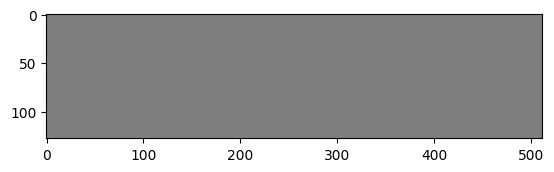

In [12]:
input_shape = (94, 94, 3)
latent_dim = 32


class VAE(Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=input_shape),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim*2, activation='selu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(1024, activation='selu', input_shape=(latent_dim,)),
            layers.BatchNormalization(),
            layers.Dense(187392, activation='selu'),
            layers.Reshape((61, 256, 10)),
            layers.Conv2DTranspose(256, (5, 5), activation=LeakyReLU(0.02), strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.Conv2DTranspose(128, (5, 5), activation=LeakyReLU(0.02), strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.Conv2DTranspose(64, (5, 5), activation=LeakyReLU(0.02), strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.Conv2DTranspose(32, (5, 5), activation=LeakyReLU(0.02), strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.Conv2DTranspose(3, (5, 5), activation='sigmoid', strides=1, padding='same'),
            layers.BatchNormalization()
        ])

    def call(self, X):
        mu, sigma = tf.split(self.encoder(X), num_or_size_splits=2, axis=-1)
        epsilon = tf.random.normal(tf.shape(sigma))
        z = mu + epsilon * tf.exp(0.5 * sigma)
        reconstruction = self.decoder(z)
        return reconstruction


path = '../data/'
images = os.listdir(path)
image = load_image(path + images[1])

latent_dim = 32

model = VAE(latent_dim)
output = (model(image)[0] * 255.0).numpy().astype(int)

print(output.shape)
plt.imshow(output, cmap='gray')
plt.show()

In [ ]:
optmizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 100

for epoch in range(epochs):
    for image in images:
        with tf.GradientTape() as tape:
            reconstructed = model(path + image)

